To-dos
* Use big_flare_finder module to train model and run inference on the test set


In [1]:
# set globals

# do Google Colab things
try:
    from google.colab import drive

    drive.mount("/content/drive", force_remount=True)
    IN_COLAB = True
except:
    IN_COLAB = False

# install dependencies
path_to_coderepo = (
    "/content/drive/MyDrive/ML_project/code_repo/flare-finder" if IN_COLAB else "."
)
if IN_COLAB:
    !pip install -r {path_to_coderepo}/requirements.txt

# import standard libraries
import matplotlib.pyplot as plt
import pandas as pd
import sys

# import custom libraries
if f'{path_to_coderepo}/src' not in sys.path:
    sys.path.append(f'{path_to_coderepo}/src')
from big_flare_finder import BigFlareFinder

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.4/205.4 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.5.1 which is incom

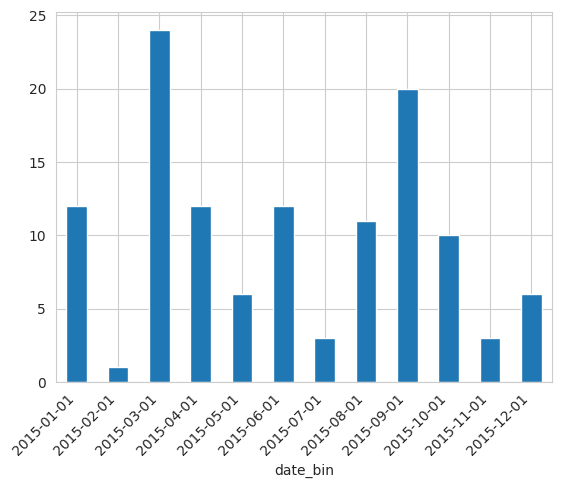

In [14]:
# plot histogram of big flares as a function of month

# set the style of plotting to seaborn whitegrid
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

# get the image data: image_paths, image_labels
image_folder_path = f"{path_to_coderepo}/../../data/sdo_images_w=131a"
big_flare_labels_df = pd.read_csv(f"{image_folder_path}/big_flare_labels.csv").dropna().sort_values('solar_image_filename')

# get datetime from solar_image_filename in big_flare_labels_df
big_flare_labels_df['datetime'] = pd.to_datetime(big_flare_labels_df['solar_image_filename'].str.split('.').str[0], errors = 'coerce')

# bin datetime to first day of month
big_flare_labels_df['date_bin'] = big_flare_labels_df['datetime'].dt.to_period('M').dt.to_timestamp()

# groupby date_bin and sum is_big_flare
# rotate the x axis labels
ax = big_flare_labels_df.groupby('date_bin')['is_big_flare'].sum().plot(kind='bar')
plt.xticks(rotation=45, ha='right')
_ = ax.set_xticklabels([label.get_text()[:10] for label in ax.get_xticklabels()])

In [15]:
big_flare_labels_df.head()

,solar_image_filename,is_big_flare,datetime,date_bin
18,2015-01-01 00:00:10.070000+00:00.png,0.0,2015-01-01 00:00:10,2015-01-01
4145,2015-01-01 01:00:10.070000+00:00.png,0.0,2015-01-01 01:00:10,2015-01-01
2497,2015-01-01 02:00:10.070000+00:00.png,0.0,2015-01-01 02:00:10,2015-01-01
1807,2015-01-01 03:00:10.070000+00:00.png,0.0,2015-01-01 03:00:10,2015-01-01
1276,2015-01-01 04:00:10.070000+00:00.png,0.0,2015-01-01 04:00:10,2015-01-01


In [16]:
# Filter big_flare_labels_df to include only rows within the first 8 months
first_8_months_df = big_flare_labels_df[
    (big_flare_labels_df['date_bin'] >= '2015-01-01') &
    (big_flare_labels_df['date_bin'] <= '2015-08-01')
]

# Get the number of rows in the filtered DataFrame
num_rows_first_8_months = first_8_months_df.shape[0]

# Print the number of rows
print(f"Number of rows in the first 8 months: {num_rows_first_8_months}")

Number of rows in the first 8 months: 4007


In [20]:
# We want to use big_flare_finder module to train model and run inference on the test set

# get the image data: image_paths, image_labels
image_folder_path = f"{path_to_coderepo}/../../data/sdo_images_w=131a"
big_flare_labels_df = pd.read_csv(f"{image_folder_path}/big_flare_labels.csv").dropna()

# [TEMP] shorten big_flare_labels_df
big_flare_labels_df = big_flare_labels_df.sort_values('solar_image_filename').iloc[None:None]

image_paths = (
    image_folder_path + "/" + big_flare_labels_df["solar_image_filename"]
).to_list()
image_labels = big_flare_labels_df["is_big_flare"].to_list()

# split image_paths and image_labels by time:
#     image_paths_train, image_paths_test, image_labels_train, image_labels_test
test_frac = 0.5
image_paths_train, image_paths_test, image_labels_train, image_labels_test = (
    BigFlareFinder.split_into_train_test_by_time(image_paths, image_labels, test_frac)
)

# # train model
# big_flare_finder = BigFlareFinder()
# model = big_flare_finder.fit(image_paths_train, image_labels_train)

# # get prediction probabilites
# image_pred_probas_test = big_flare_finder.pred_proba(image_paths_test)
# print(f"\nimage_pred_probas_test: {image_pred_probas_test}")

ValueError: time data "2015-11-09 13:12:11+00:00" doesn't match format "%Y-%m-%d %H:%M:%S.%f%z", at position 5163. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [4]:
# compare pred_proba labels to pred labels
# * we start with the fitted model big_flare_finder, and the test image_paths
# * get the pred_proba labels and the predict labels

pred_probas = big_flare_finder.pred_proba(image_paths_test)
pred_probas_labels = [1 if pred_proba > 0.5 else 0 for pred_proba in pred_probas]
predict_labels = big_flare_finder.predict(image_paths_test)

# check if pred_probas_labels is equal to predict_labels
if pred_probas_labels == predict_labels:
    print("pred_probas_labels is equal to predict_labels")
else:
    print("pred_probas_labels is not equal to predict_labels")


pred_probas_labels is equal to predict_labels


In [ ]:
# get predict() performance of model on test data

# get the image data: image_paths, image_labels
image_folder_path = f"{path_to_coderepo}/../../data/sdo_images_w=131a"
big_flare_labels_df = pd.read_csv(f"{image_folder_path}/big_flare_labels.csv").dropna()

# [TEMP] shorten big_flare_labels_df
big_flare_labels_df = big_flare_labels_df.sort_values('solar_image_filename').iloc[None:500]

image_paths = (
    image_folder_path + "/" + big_flare_labels_df["solar_image_filename"]
).to_list()
image_labels = big_flare_labels_df["is_big_flare"].to_list()

# split image_paths and image_labels by time:
#     image_paths_train, image_paths_test, image_labels_train, image_labels_test
test_frac = 0.5
image_paths_train, image_paths_test, image_labels_train, image_labels_test = (
    BigFlareFinder.split_into_train_test_by_time(image_paths, image_labels, test_frac)
)

# train model
big_flare_finder = BigFlareFinder()
model = big_flare_finder.fit(image_paths_train, image_labels_train)

# make predictions
image_labels_test_pred = big_flare_finder.predict(image_paths_test)

# get pred metrics
test_metrics = BigFlareFinder.get_model_performance_metrics(image_labels_test, image_labels_test_pred)
print(f"\ntest_metrics: {test_metrics}")

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


Train epoch: 0, train_loss: 0.28
val_metrics: {'accuracy': 0.98, 'f1': 0.0, 'precision_class_1': 0.0, 'recall_class_1': 0.0, 'actual_distru': {0.0: 136, 1.0: 3}, 'pred_distru': {0: 139}}
Train epoch: 1, train_loss: 0.08
val_metrics: {'accuracy': 0.98, 'f1': 0.0, 'precision_class_1': 0.0, 'recall_class_1': 0.0, 'actual_distru': {0.0: 136, 1.0: 3}, 'pred_distru': {0: 139}}
Train epoch: 2, train_loss: 0.05
val_metrics: {'accuracy': 0.98, 'f1': 0.0, 'precision_class_1': 0.0, 'recall_class_1': 0.0, 'actual_distru': {0.0: 136, 1.0: 3}, 'pred_distru': {0: 139}}
Train epoch: 3, train_loss: 0.03
val_metrics: {'accuracy': 0.98, 'f1': 0.0, 'precision_class_1': 0.0, 'recall_class_1': 0.0, 'actual_distru': {0.0: 136, 1.0: 3}, 'pred_distru': {0: 139}}
Train epoch: 4, train_loss: 0.04
val_metrics: {'accuracy': 0.98, 'f1': 0.0, 'precision_class_1': 0.0, 'recall_class_1': 0.0, 'actual_distru': {0.0: 136, 1.0: 3}, 'pred_distru': {0: 139}}
Train epoch: 5, train_loss: 0.03
val_metrics: {'accuracy': 0.98, 

In [ ]:
# train big-flare classifier
# * train big-flare classifier on first 70% of 2015 and test on last 30%
# * show prediction-quality (accuracy, f1, precn, recall)



In [ ]:
# show the timeline of flares in test along with predictions

In [ ]:
# show what the model learned
# * some viz of features picked up by the model for big-flares